## DeepDream

**Fetching the test image**

In [365]:
from tensorflow.keras.utils import get_file, load_img, save_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
K.clear_session()

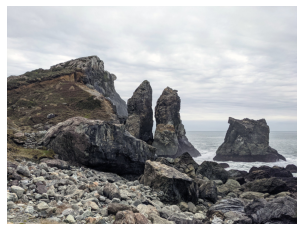

In [366]:
image = get_file("coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")
plt.axis("off")
plt.imshow(load_img(image))

**Instantiating a pretrained `InceptionV3` model**

In [367]:
model = InceptionV3(weights="imagenet", include_top=False)

In [368]:
for layer in model.layers:
    print(layer.name)

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

**Configuring the contribution of each layer to the DeepDream loss**

In [369]:
settings = {
    "activation_50": 1.0,
    "activation_60": 1.5,
    "activation_76": 2.0,
    "activation_83": 2.5,
}

In [370]:
outputs = {
    name: model.get_layer(name).output for name in settings.keys()
}

In [371]:
feature_extractor = Model(inputs=model.inputs, outputs=outputs)

**The DeepDream loss**

In [372]:
def compute_loss(input_image):
    
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    
    for name in features.keys():
        coeff = settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    
    return loss

**Gradient ascent process**

In [373]:
@tf.function
def gradient_ascent_step(image, learning_rate):
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    
    for i in range(iterations):
        
        loss, image = gradient_ascent_step(image, learning_rate)
        
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    
    return image

**Image processing utilities**

In [374]:
def preprocess_image(image_path):

    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    return img

def deprocess_image(img):
    
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    
    return img

**Running gradient ascent over multiple successive "octaves"**

In [375]:
num_octave = 3
octave_scale = 1.4

In [376]:
original_img = preprocess_image(image)
original_shape = original_img.shape[1:3]
successive_shapes = [original_shape]

In [377]:
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

In [378]:
learning_rate = 20.
iterations = 30
max_loss = 15.

In [379]:
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])
img = tf.identity(original_img)

for i, shape in enumerate(successive_shapes):
    
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, iterations=iterations, learning_rate=learning_rate, max_loss=max_loss)
    
    upscaled_shrunk_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    
    lost_detail = same_size_original - upscaled_shrunk_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)
    
deep_dream_image = deprocess_image(img.numpy())

Processing octave 0 with shape (459, 612)
... Loss value at step 0: 0.41
... Loss value at step 1: 0.68
... Loss value at step 2: 0.86
... Loss value at step 3: 0.90
... Loss value at step 4: 1.20
... Loss value at step 5: 1.09
... Loss value at step 6: 1.37
... Loss value at step 7: 1.49
... Loss value at step 8: 1.86
... Loss value at step 9: 1.86
... Loss value at step 10: 2.19
... Loss value at step 11: 2.23
... Loss value at step 12: 2.82
... Loss value at step 13: 2.80
... Loss value at step 14: 3.15
... Loss value at step 15: 3.48
... Loss value at step 16: 3.30
... Loss value at step 17: 3.98
... Loss value at step 18: 3.80
... Loss value at step 19: 4.64
... Loss value at step 20: 4.41
... Loss value at step 21: 5.03
... Loss value at step 22: 5.70
... Loss value at step 23: 5.79
... Loss value at step 24: 5.54
... Loss value at step 25: 5.87
... Loss value at step 26: 6.38
... Loss value at step 27: 6.44
... Loss value at step 28: 6.55
... Loss value at step 29: 6.87
Processi

In [380]:
save_img("deep-dream.png", deep_dream_image)

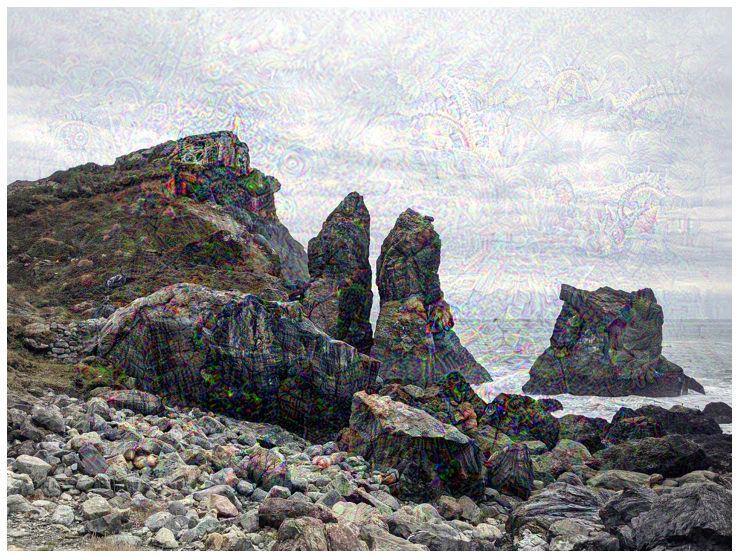

In [381]:
plt.figure(figsize = (80, 10))
plt.axis("off")
plt.imshow(deep_dream_image)